In [15]:
import sys

sys.argv = [""]
del sys

In [16]:
import cv2
import argparse
import numpy as np
import torch

import matplotlib.pyplot as plt

In [17]:
def create_cfg(args):
    parser = argparse.ArgumentParser()
    for key, val in args.items():
        parser.add_argument(key, default=val)

    cfg = parser.parse_args()
    return cfg

In [91]:
img = cv2.imread('../samples/test/1_raw.png')
mask = cv2.imread('../samples/test/1_mask.png')

In [92]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

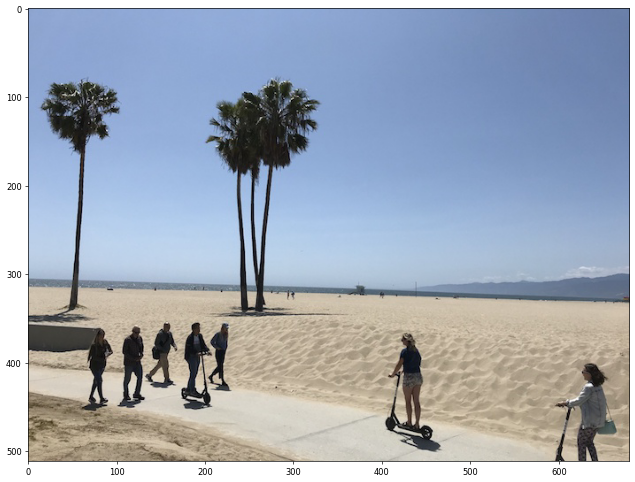

In [93]:
plt.figure(figsize=(20,10), dpi=60)
plt.imshow(img)

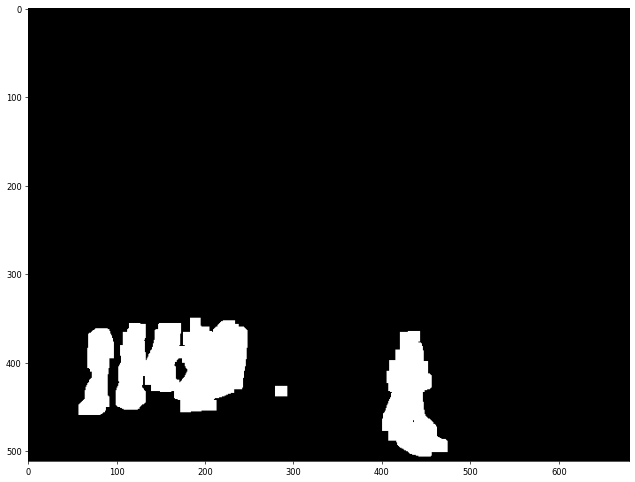

In [94]:
plt.figure(figsize=(20,10), dpi=60)
plt.imshow(mask)

In [95]:
mask = mask[:,:,:1]
mask.shape

(512, 680, 1)

In [96]:
mask = np.transpose(mask, (2,0,1))
mask.shape

(1, 512, 680)

In [97]:
np.unique(mask)

array([  0, 255], dtype=uint8)

In [98]:
mask[np.where(mask==255)] = 1
np.unique(mask)

array([0, 1], dtype=uint8)

In [99]:
img = np.transpose(img, (2,0,1))
img.shape

(3, 512, 680)

In [100]:
img = img.astype(np.float32)
mask = mask.astype(np.float32)

img.dtype, mask.dtype

(dtype('float32'), dtype('float32'))

___

Fix required: masked_image not displaying correctly 

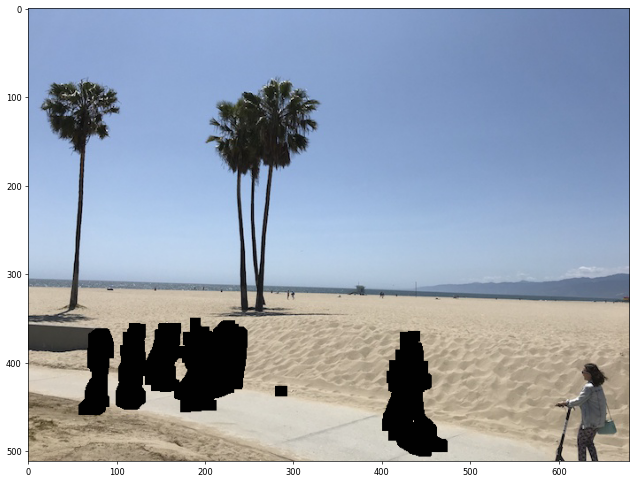

In [101]:
masked_img = img * (1 - mask) + mask

masked_img = np.transpose(masked_img, (1,2,0)).astype(np.uint8)

plt.figure(figsize=(20,10), dpi=60)
plt.imshow(masked_img)

___

1. load generator from best model checkpoint


In [16]:
from inpaint.core.generator import GatedGenerator

In [47]:
args = {}

# model | generator config
args["--in_channels"] = 4
args["--out_channels"] = 3
args["--latent_channels"] = 64
args["--pad_type"] = "zero"
args["--activation"] = "elu"
args["--norm_d"] = "none"
args["--norm_g"] = "batch"
args["--init_type"] = "kaiming"
args["--init_gain"] = 0.02
args["--use_cuda"] = True
args["--use_perceptualnet"] = True
args["--sn_enable"] = True
args["--add_context_attention"] = True

In [19]:
cfg = create_cfg(args)

In [20]:
generator = GatedGenerator(cfg)

ckpt_path = "../../../experiments/inpaint/ckpts/exp7/best_models_final.pth"

models = torch.load(ckpt_path, map_location=torch.device('cpu'))
gen_model_state_dict = models["generator_state_dict"]

generator.load_state_dict(gen_model_state_dict)

<All keys matched successfully>

___
2. pass generator, img and mask to predict method
   img shape (3, H, W) and mask shape (1, H, W)

In [21]:
from inpaint.tools import predict

In [22]:
output = predict(generator, img, mask)

/home/goswami.p/miniconda3/envs/inpaint/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/home/goswami.p/miniconda3/envs/inpaint/lib/python3.8/site-packages/inpaint-0.1.0-py3.8.egg/inpaint/core/modules/attention.py:194: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


___
3. Visualize predicted image

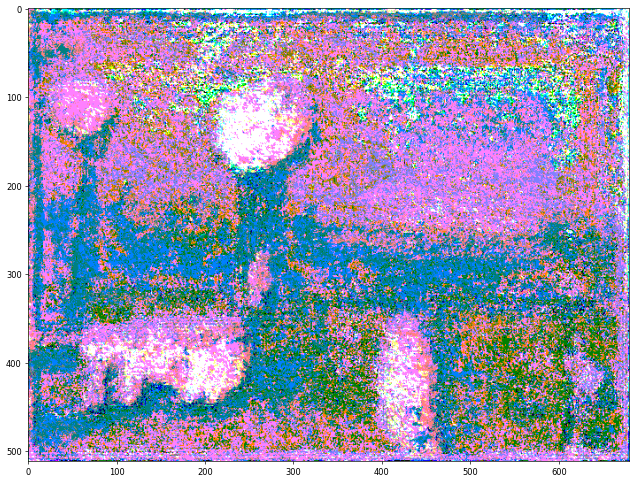

In [23]:
plt.figure(figsize=(20,10), dpi=60)
plt.imshow(output)

In [70]:
import torch
import torchvision.transforms as transforms

In [85]:
normalize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        )
    ])

In [86]:
img.shape

(3, 512, 680)

In [87]:
norm_img = normalize(img)

RuntimeError: The size of tensor a (680) must match the size of tensor b (3) at non-singleton dimension 0

In [89]:
norm_img

tensor([[[140., 141., 141.,  ..., 183., 177., 189.],
         [163., 164., 164.,  ..., 166., 160., 172.],
         [205., 206., 206.,  ..., 139., 133., 145.]],

        [[141., 141., 142.,  ..., 181., 178., 177.],
         [164., 164., 165.,  ..., 164., 161., 160.],
         [206., 206., 207.,  ..., 137., 134., 133.]],

        [[141., 141., 141.,  ..., 178., 175., 172.],
         [164., 164., 164.,  ..., 161., 158., 155.],
         [206., 206., 206.,  ..., 134., 131., 128.]],

        ...,

        [[105., 105., 105.,  ..., 196., 202., 201.],
         [127., 127., 127.,  ..., 180., 186., 185.],
         [168., 168., 168.,  ..., 157., 163., 162.]],

        [[105., 106., 106.,  ..., 189., 197., 201.],
         [127., 128., 128.,  ..., 171., 179., 183.],
         [168., 169., 169.,  ..., 149., 157., 161.]],

        [[106., 106., 106.,  ..., 175., 189., 211.],
         [128., 128., 128.,  ..., 157., 171., 193.],
         [169., 169., 169.,  ..., 135., 149., 171.]]])